# Data Science Case Study

Project Goal: To train a sentiment classifier on a corpus of provided documents in order to maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled. Describe the business outcomes including how data limitations impact your results and how these limitations could be addressed in a larger project.

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import shutil

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt 

### 1. Data

The Roman Urdu Data Set Data Set contains about 20,000 rows and two columns.  The columns contain the text and sentiment -- negative, positve and neutral.  The text field contains punctuation, missing fields, capitilization, words form other languages and some non-text characters. 

There are several identical entries in the text column which have different label sentiments.  Based on the information given, that the social media company wants to identify negative sentiment, it is assumed that this is not a multi-label classification problem.  That any given phrase or sentence will only would either be positive, neutral or negative, and not some combination of the classes.

Additionally, a large number of inconsistently labeled entries might lessen the ability to delineate the feature space. The negatively labeled rows make up about a quarter of the dataset. In an attempt to identify inconsistently labeled text, the text was converted to lower case in order to complete a comparison evalutaion besed on the value of each entry. 

**Import Dataset**

In [2]:
flat_file = pd.read_csv('Roman Urdu DataSet.csv',
                names = ['text', 'sentiment', 'unamed'], dtype = {'text': str, 'sentiment': str})
#size of dataset 
flat_file.shape 

(20229, 3)

**Description of Data**

In [3]:
flat_file.head()

,text,sentiment,unamed
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


**Label Distribution**

In [4]:
flat_file.sentiment.value_counts()

Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: sentiment, dtype: int64

**Convert all text to lowercase**

In [5]:
flat_file.iloc[:,0] = flat_file.text.str.strip().str.lower()

### 2. Compare Labels

Four looping functions are used to compare the text, and to identify **inconsistently labeled** data:
    
    1. similar_text
    
    2. Index_duplicates
    
    3. dupe_drop
    
    4. drop_text
    
Nested for loops are used to search through the rows to find duplicates.  This is an expensive operation, especially for larger datasets.  The  '==' comparison is used in case any of the text with the same value do not also point to the same object.  The approach is first to find identical row entries, to use that collection to search through the dataset to find the indices of dulpicative entries, to evaluate if duplicative entries have two or more labels and if so do to drop identical entries with two or more different classes from the analysis.  

**Nested loops to cycle through the data to find duplicates**

In [6]:
def similar_text(list_values):
    '''Extract subset from text column with same value '''
    text_list = []

    for i in range(len(list_values)):
        count = 0
        
        for j in range(len(list_values)):
            
            if list_values[i] == list_values[j]:
                count+=1
                
        if (count > 2):
            
            text_list.append(list_values[i])
    
    return set(text_list)

**Create list of indices where duplicates exist**

In [7]:
def index_duplicates(duplicate, dupe_df):
    
    '''return indices of duplicates '''
    
    dupe_index = []
    
    for i in range(len(dupe_df.text)):
        
        if dupe_df.text[i] == duplicate:
            
            dupe_index.append(i)
            
    return dupe_index

**Check for more than one label**

In [8]:
def dupe_drop(dupe_list, dupe_df):
    
    '''return if text if text has more than one label''' 
    
    df = dupe_df.iloc[dupe_list]
    
    if len(set(df.sentiment))!=1:
        
        return df.text[dupe_list[0]]

**Example of non-text data that has also been inconsistently labeled**

In [9]:
dp_ind = index_duplicates(':)', flat_file)
df = flat_file.loc[dp_ind]
df

,text,sentiment,unamed
7791,:),Neutral,NaN
8181,:),Neutral,NaN
10594,:),Negative,NaN


**Drop only duplicates with two or more labels**

In [10]:
def drop_text(dupeList, df):
    
    '''text and index of text to drop from corpus dataset'''
    
    totalText = []
    totalIndices = []
    
    #list of duplicates 
    dupeList = list(dupeList)
    
    for dupe in (dupeList):
        
        #get indices of duplicates 
        dpList = index_duplicates(dupe, df)
        
        #return instances of duplicates with more than one label 
        dupe_name = dupe_drop(dpList, df)
        
        if dupe_name is not None:
            totalText.append(dupe_name)
            
            for i in range(len(dpList)):
            
                totalIndices.append(dpList[i])
        
    return totalText, totalIndices

**This is list of test with different sentiment**

In [11]:
# find duplicative text 
duplicates = similar_text(list(flat_file.text))

#identify text to drop
drop_these, dropIndices = drop_text(duplicates, flat_file)

drop_these

['hahahah',
 'haha',
 'wah',
 'lol',
 'bilkul',
 'jee ye to he',
 'hahahha',
 'bilkul sahi',
 ':)',
 'hahahaha',
 'acha',
 'shadi ka na hona, jadu ka toor, bimariyan, shoar ko apna bana ,jumla masil ka rohani haal mojod ha mayoos afrad rabta kren masla hal ho jaen ga inshallah.']

### 3. Preprocessing

The pre-processing steps are aimed at reducing all non-character format including punctutation.  The unamed axis is also dropped.  All blank text, and series of blank text is reduced and then dropped. One label misspelled label is amended. 

In [12]:
def pre_processing(df):
    
    '''Pre-process flat file removing puntuation, dropping blank rows and labeling'''

    # drop inconsistently labeled rows
    corpus = df.drop(dropIndices, axis = 0)

    #drop unamed column
    corpus = corpus.drop(labels = 'unamed', axis = 1)

    #remove anything that is not space or character
    corpus.text = corpus.text.str.replace('[^\s\w]', ' ')
    # remove digits, newline and _ char
    corpus.text = corpus.text.str.replace('[\d\n_]', ' ')
    
    #replace two or more spaces with one space
    corpus.text = corpus.text.str.replace('[ ]{2,}', ' ')

    #drop blank sentiment 
    single_s = corpus.text.loc[corpus.text == ' '].index[:]
    
    #make list
    t_space = list(single_s) 

    #drop rows without blank text 
    corpus = corpus.drop(t_space, axis = 0)
    
    # replace blank cells with nans
    corpus.text.replace([''], np.nan, inplace=True)
    
    # drop nan columns
    corpus.dropna(axis = 0, inplace = True)
    
    # re-label sentiment 
    corpus.sentiment = ['Negative' if x == 'Neative' else x for x in corpus.sentiment]

    corpus.sentiment = [1 if x == 'Negative' else 0 for x in corpus.sentiment]
    
    return corpus

**Resulting cleaner dataset, re-indexed and relabled** 

In [13]:
# resulting data post processing  
corpus = pre_processing(flat_file)

corpus = corpus.reset_index(drop=True)

**Number of rows removed**

In [14]:
flat_file.shape[0] - corpus.shape[0]

259

The labels have been reassigned combining the postive and neutral classes which are indicated with zeros, and negative class is indicated by 1's.  This change from a multi-classification problem to a binary one seems to align with the business objective to identify negative sentiment, and is thought to improve the accuracy of identifying negative sentiment.

In [15]:
#description of resulting set of sentiment  
print(corpus.sentiment.value_counts())

corpus.head()

0    14685
1     5285
Name: sentiment, dtype: int64


,text,sentiment
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,0
1,sahi bt h,0
2,kya bt hai,0
3,wah je wah,0
4,are wha kaya bat hai,0


### 4. Encode text field with vocab dictionary

In [16]:
#using Count Vectorizer to get unique words from text column 
text_list = list(corpus.text)

vector = CountVectorizer(analyzer='word')

vocab_table =  vector.fit_transform(text_list)

# resulting vocabulary 
vocab = vector.get_feature_names()

**The CountVecorizer class is used to find the unique vocabulary of the text field**

There are more than **31,000** unique words/characters used in the vocabulary

**Vocabulary Dictionary**

In [17]:
# Encoded dictionary assigning each word to a number  

vocab_dict = {}

for i, word in enumerate(vocab, start = 1):
    
    vocab_dict.update({word: i})

**Encode Text** 

In [18]:
encode_corpus = []
characters  = []

# encode code each sentence in text column using the vocab_dict
for i in range(len(text_list)):
    
    encode_sentence = []

    for word in text_list[i].split():
        
        try:
    
            encode_sentence.append(vocab_dict[word])
        
        except:
            
            # characters not found in vocab_dict
            characters.append(word)
    
    encode_corpus.append(encode_sentence)        
        

Each row has been encoded using the vocabulary dictionary: **vocab_dict** <br>

The sample entry below at row index 15305 contains five different words.

In [19]:
encode_corpus[15305]

[18264, 1243, 23439, 8832, 1378]

During the encoding process there were several instances where characters were not found in the vocabulary dictionary and therefore were not able to be encoded.  **There were 29 different characters that were not contained in the dictionary.**  These letters were not added to the dictionary.  In a TF-IDF approach these items would have likely been "Stop Words" and removed.  It is also possible that these letters form were part of contraction in which case theoritically a lemmatized version of the word still remains in the corpus. 

In [20]:
#exceptions - not encoded 
len(set(characters))

29

### 5. Standardize word vector length

In [21]:
#count frequency of sequence length found in text 
freq = []
for line in encode_corpus:
    m = len(line)
    freq.append(m)

The graph below shows depicts the number of words in a row and the x axis indicates that there are about 20,000 rows in the dataset.<br>

The median number of words in row is: **9**

The average number of words in a row is about: **13**

The max number of words in row is: **288**

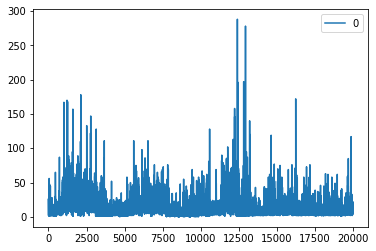

In [24]:
#frequency distribution of length of text   
pd.DataFrame(freq).plot(kind='line')

**Padding the length of Vector Inputs**

In [25]:
def pad_input(list_of_list, length_int):
    
    '''pad text input with zeros to provide standard input for model'''

    pad_corpus = []
    
    seq_length = []
    
    drop_indices  = []

    for i in range(len(list_of_list)):
        
        # padding word vectors 
        
        if (len(list_of_list[i]) <= length_int) and (len(list_of_list[i]) > 0):
            
            # adding zeros 
            zeros = list(np.zeros(length_int - len(list_of_list[i]), dtype = int))

            total = zeros + list_of_list[i]
            
            pad_corpus.append(total)
            
            seq_length.append(len(list_of_list[i]))          
        
        #truncate 
        
        elif len(list_of_list[i]) > length_int:

            pad = list_of_list[i][:length_int]

            pad_corpus.append(pad)
            
            seq_length.append(len(list_of_list[i]))    
        
        # error checking 
        else:
            
            drop_indices.append(i)
                 
    return pad_corpus, seq_length, drop_indices      

The pad_input function (above) counts the number of words in a row and either truncates the text or add zeros (from left to right to ensure that each row of input is of equal length. 

In [91]:
vector_length = 40

#pad_text - contains all the encoded equal length vectors 

pad_corpus, seq, drop_indices = pad_input(encode_corpus, vector_length)

# labels 
y = corpus.sentiment

**Error Checking**

During the padding process, additional issues were discovered.  The variable **drop_indices** contains the additional list of rows that will be dropped.  Many of these instances are of empty list that may have been created during the encoding process when the set of 29 characters were not encoded.  These instances that may require further discussion to best understand how to code a more comprehensive pre-processing step that catches more edge cases and improves data quality.<br>

This further reduces the number of rows by additional **35** rows. That brings the total number of dropped rows to **294** rows or about **1.5%** of the data.<br>

It also means that the labels will have also have to be amended

In [92]:
def y_clean(y, list_index):
    
    # remove labels aligned to bad data
    
    y_new = []
    
    for i in range(len(y)):
        
        if i not in list_index:
            
            y_new.append(y[i])
        
    return y_new 

**The features and labels used in the model**

In [93]:
labels = y_clean(y, drop_indices)

features = pad_corpus

### Training, Validation and Testing Subsections of the Data

In [94]:
X_train, X_base, y_train, y_base = train_test_split(features[:len(features)-1], 
                                                    labels[:len(labels)-1], test_size=.20006, random_state=305)

X_test, X_val, y_test, y_val = train_test_split(X_base, y_base, test_size=.5, random_state=305)

**The model is trained on about 80% percent of the data, leaving 10% for each of the validation and testing sections**

In [95]:
print('Training set contains {} X samples and {} y samples'.format(len(X_train),len(y_train)))
print('Validation set contains {} X samples and {} y samples'.format(len(X_val),len(y_val)))
print('Test set contains {} X samples and {} y samples'.format(len(X_test),len(y_test)))


Training set contains 15946 X samples and 15946 y samples
Validation set contains 1994 X samples and 1994 y samples
Test set contains 1994 X samples and 1994 y samples


**Creating TensorDatasets**

In [96]:
train = TensorDataset(torch.from_numpy(np.asarray(X_train)), torch.from_numpy(np.asarray(y_train)))
val = TensorDataset(torch.from_numpy(np.asarray(X_val)), torch.from_numpy(np.asarray(y_val)))
test = TensorDataset(torch.from_numpy(np.asarray(X_test)), torch.from_numpy(np.asarray(y_test)))

### Creating DataLoaders Generators

**Batch Size**

The batch size is for this model is 2.  The batch size was driven by the desire do not arbitraily drop data.  The generators require that batch size is a multiple of each data subsection --training, validation, test.  However, the smaller batch size reduces the memory used at any given time facilitating larger models, this at the cost of higher fluctuations of performance metrics during training.

In [97]:
# batch size 
size = 2

# create data load generators 

train_load = DataLoader(train, shuffle = True, batch_size=size)

val_load = DataLoader(val, shuffle = True, batch_size=size)

test_load = DataLoader(test, shuffle = True, batch_size=size)

**Model Selection**

The model implemented here is a RNN that uses a stacked LSTM cell that passes state in the forward direction.  The model consists of an embedding layer (dimensions vocabulary x embed_dim), dropout layers to reduce overfitting and improve the chances that the model will generalize well on new data.  The model also consists of a dense, linear layer and passes the final output through a sigmoid activation layer.

### 6. LSTM Model Architecture

In [98]:
class romanModel(nn.Module):
    
    "RNN model to classify sentiment"
    
    def __init__(self, vocab, output, embed_dim, hidden_dim, size_var, n_layers, drop=.3):
        
        super(romanModel, self).__init__()
        
        self.output = output
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = size_var
        
        # initialize embedding layer
        self.embedding = nn.Embedding(vocab, embed_dim)
        
        # initialize lstm layer 
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first = True, dropout = drop)
        
        # initialize dropout layer 
        self.dp_layer = nn.Dropout(drop)
        
        # initalilize fully connected linear layer
        self.fully_connected = nn.Linear(hidden_dim, output)
        
        # sigmoid activation 
        self.activation = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # first dim of input 
        self.batch_size = x.size(0)
        
        #convert tensor to long type
        x = x.long()
        
        #feed input into embedding layer
        embeds = self.embedding(x)
        
        # -output: (batch, seq length, hidden_dim) - hidden - 2x (num layers, batch, hidden_dims)
        out, hidden = self.lstm(embeds, hidden)
        
        #apply dropout layer 
        out = self.dp_layer(out)
        
        # linear layer (batch, seq length, 1)
        out = self.fully_connected(out)
        
        #sigmoid layer (batch, seq length, 1) 0-1
        out = self.activation(out)
        
        #separate by batch (batch, embed_dim) 
        out = out.view(self.batch_size, -1)
        
        # take last value from each batch (batch) 
        out = out[:, -1]
        
        return out, hidden
    
    def hidden_state(self):
        
        '''size hidden and cell state tensors'''
        
        weight = next(self.parameters())
        
        if(gpu):   
            # sized hidden state placed on Gpu
            hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().cuda(), 
                      weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().cuda())
        
        else:
            
            hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

    

### 7. Model Parameters

The model parameters were listed below.  of the listed parameters vector_length (the length of the input), the embed dimension and the hidden dimension were of most interest.  In general, increasing either vector length or the hidden parameters has not resulted in signifcant better model performance.<br>

Increasing vector length also increases the number of placeholder (padded) non-useful inputs into the dataset, but more work could be done to design more comprehensive training jobs to have a better understanding as to how each parameter impacts the results of the model performance.

In [99]:
# model architecture 
n_layers = 2
output_var = 1
embed_dim = 600
hidden_dim = 256
size_var = size
vocab_length = len(vocab) + 1

# training parameters 
epoch = 2
clip = 5

model = romanModel(vocab_length, output_var, embed_dim, hidden_dim, size_var, n_layers)

# model parameters 
learning_rate = .001
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


**The latest and best validation model are saved during training**

In [100]:
#save best model - avg validation loss

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar') 
        
        print('Model Saved.........................................' )

### 8. Training 

The model trains with relatively few passes through the data.  The number of epochs taken is reduced to capture the best model before increased overfitting begins to occur.<br>

In order to train the larger models and explore more permutations of parameters the best model is not picked up to produce the results.  This was done to reduce the need load more data into memory, however the number of epochs was estimated so that the best model would be used to infer the evaluation results. 

In [101]:
gpu = torch.cuda.is_available()

if (gpu):
    model.cuda()
    print('Training on GPU has started...')

count_row = 0
best_val = 1
model.train()

for i in range(epoch):
    print('Epoch...', i+1)
    # initialize hidden input 
    hid = model.hidden_state()
    # cycle training data 
    validation_loss = []
    train_loss = 0
    
    for features, labels in (train_load):
        
        #move to gpu
        if (gpu):
            
            features = features.cuda()
            labels = labels.cuda()
        
        count_row +=1
        
        # zero gradient 
        optimizer.zero_grad()
        
        # input features and hidden state, model outputs projection and hidden state 
        output, hid = model(features, hid)
        
        hid = (hid[0].detach(), hid[0].detach())
        
        # binary cross entropy loss
        loss = loss_function(output, labels.float())
        
        # calculate the gradient 
        loss.backward()
        
        # limit size of gradient 
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        #update with gradient 
        optimizer.step()
        
        # interval set to quarters 
        interval = int((len(X_train)/size)/4)
        
        if count_row % interval == 0: 
            
            print('Epoch progress...', round(((count_row/(len(X_train)/size))-i), 2))           
            
            # initialize hidden state
            hid_val = model.hidden_state()
            
            #set model to evaluation mode
            model.eval()
            
            #cycle through validation data 
            for features_val, labels_val in val_load:
                
                if (gpu):
                    
                    features_val = features_val.cuda()
                    labels_val = labels_val.cuda()                

                output_val, hid_val = model(features_val, hid_val)
                
                # validation loss metirc 
                loss_val = loss_function(output_val, labels_val.float())
                
                #record validation metrics per batch
                validation_loss.append(loss_val.item())

            # reset model to train mode
            model.train()
        
        train_loss += loss.item()
        
    # validation metric 
    current_val = sum(validation_loss)/len(validation_loss)

    #compare model metrics
    is_best = current_val < best_val

    best_val = min(current_val, best_val)

    #model state 
    best_state = {

        'epoch': i+1,
        'state_dict' : model.state_dict(),
        'opt_dict' : optimizer.state_dict(), 
    }

    #checkpoint model 
    save_checkpoint(best_state, is_best, filename='checkpoint.pth.tar')  
     
    #print training metrics     
    print('Training loss....', train_loss/(count_row/size))
    print('Validation loss...', sum(validation_loss)/len(validation_loss))
        

Training on GPU has started...
Epoch... 1
Epoch progress... 0.25
Epoch progress... 0.5
Epoch progress... 0.75
Epoch progress... 1.0
Model Saved.........................................
Training loss.... 1.010295851805343
Validation loss... 0.5142550337032127
Epoch... 2
Epoch progress... 0.25
Epoch progress... 0.5
Epoch progress... 0.75
Epoch progress... 1.0
Training loss.... 0.31080721849402176
Validation loss... 0.5309591039396596


### 9. Evaluation

In [102]:
#size initial hidden states
#hid_test = model.hidden_state()

#empty lists
total_pred = []
total_labels = []

# set to evaluation mode
model.eval()

# initialize hidden state
hid_test = model.hidden_state()
    
for features_test, labels_test in test_load:

    if (gpu):

        features_test = features_test.cuda()
        labels_test = labels_test.cuda()
        model = model.cuda()


    #get predictions 
    pred, hid_test = model(features_test, hid_test)
    
    #rounded prediction tensor 
    pred = torch.round(pred)

    #predictions and labels 
    total_pred += list(pred.detach().cpu().numpy())
    total_labels += list(labels_test.detach().cpu().numpy())    

### 10. Results

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1464
           1       0.68      0.48      0.56       530

    accuracy                           0.80      1994
   macro avg       0.75      0.70      0.71      1994
weighted avg       0.79      0.80      0.79      1994



[Text(0, 0.5, 'Postive/Neutral'), Text(0, 1.5, 'Negative')]

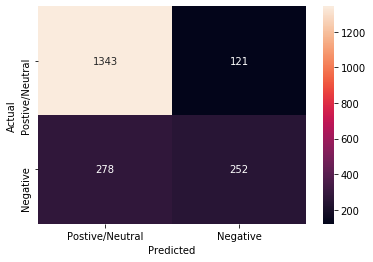

In [103]:
#confusion matrix 

print(classification_report(total_labels, total_pred))

ax = plt.subplot()
sns.heatmap(confusion_matrix(total_labels, total_pred), annot=True, fmt='g', ax = ax) 

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['Postive/Neutral', 'Negative'])
ax.yaxis.set_ticklabels(['Postive/Neutral', 'Negative'])

**The accuracy of this model, with the given parameters is about 80%** <br>

There are more false positives than false negatives so the model wrongly predicts negative sentiment more often than it fails to indicate negative sentiment.

### Business Outcomes

The primary business objective was to identify negative sentiment in the data optimizing for accuracy. This model could potentially establish the baseline for evaluating improved models.  In general, would result in models with more predictive power. In general, more accurate models should result from more data being available for training, tuning an evalutaion.

With more data, and the resources to conduct training more data could result in word embedded layers specfic to this application. An embedded layer containing the vector word representations of the words in this dataset would likely improve the model. 

With more data, one could sample it in a manner that may yield better results.  It has been mentioned, that inputs of this data have variable length, and that including vectors of longer length results in adding uneseful data.  Additional data would make it feasible to conduct analysis to better understand how the model can be optimized for certain lengths of input.  

More data would result in a more balanced dataset, which would facilitate more rigorous testing and potentially eliminate the need to resample the data. This model was found to be more effective at identifying positve/neutral data, which represents the majority of the sample. Sampling could be used to build a more balanced dataset, but at the risk of causing other issues resulting from either reusing samples or further reducing the size of the dataset.  

The test data set on which the evaluation metrics are based contain only about 2,000 records.  With more data, one would not only be more confident in the performance metrics, but also that some bias is not having some unforseen impact on how the results should be interpreted.  For example, it could be possible that this data set was taken during a time period, or during an event the skews what would ordinarily indicate a given sentiment.

More data would also inform how to select a modeling approach.  With more data, it is possible to learn that less complex, more inexpensive models could be implemented while still acheiveing a given accuracy threshold, or also that additional complexity is justified.  Support Vector Machine models preformed well on this limited dataset, but it is difficult to complete a full business case analysis of that approach compared to a deep learning approach with Attention that would likley perform better, at higher cost and complexity.  The amount of data redefines the scope of the challenge and as a result working with the amount of data expected when at scale would provide the best insight appraoch any analytic challenge.   